# <center> **Coded Apertures: Image Recostruction Test 2**<center>

- In the basic case of a 1D coded aperture sensor with a 7-elements detector array $D_{i}$, the aperture contains 13 elements (3 + 7+ 3) whose values are 1 if the element corresponds to a hole, and 0 if opaque. The source complex contains seven point sources with intensity $S_{j}$, each one projecting a different portion of the aperture $A$ onto the detector plane.

<center><img src="Images/Imaging_Layout.png" style="width:500px"/></center>

- Depending on the chosen pattern, the aperture will have a certain coding that will be projected onto the detector. In this case, the physical aperture consists of $2L - 1$ elements, so that the detector array will sample all aperture phasings, each one corresponding to an individual point source.

- Each source $S_{j}$ projects only a portion of the aperture onto the detector plane consistent with the source angular displacement relative to the camera’s optical axis or Line of Sight (LOS). The result is a composite of overlapping aperture patterns. The sum total of the recorded data constitutes the "coded" data from which the source distribution must be inferred by image reconstruction.

- To study the "efficiency" of the mask pattern, one can consider the Point Spread Function (PSF) of the sources, which represent the detector's imaging response.

- Different mask patterns can be chosen, but a general evidence is that for a large number of detector elements $L$ the PSF results narrowly peaked with sidelobes that could on average be subtracted.

- In general, performing a cross correlation between the detector image and the aperture allow us to reconstruct the sky image containing the sources $S_{j}$ with their own intensity. Large detector systems have PRFs that are narrowly peaked at zero phase.

- The physical aperture is represented as a matrix with elements 1 or 0 depending on it being respectively transparent (hole) or opaque to the incident radiation. We can write the detector response $D$ as a product between the aperture $A$ and the source distribution $S$.

- In general, we should express the encoding process by adding a background term $B$ that represents the contributions not modulated by the aperture. This would include the detector dark current, cosmic rays, and any other intrinsic detector noise contributions:
$$D = A\star S + B$$

- To reconstruct the sky image $\hat{S}$ (which results in an estimate derived from the data), we can correlate the detector image with a generalized decoding array $G$ acting on the data such that:
$$\hat{S} = G\star D = G\star(A\star S + B) = (G\star A)\star S + G\star B$$

- If one chooses $G$ such that $G\star A = \delta$, the reconstructed image will be artifact free (neglecting the background). So, looking for an aperture and decoding function that are correlating inverses of each other $G = A^{-1}$, the reconstruction will result in:
$$\hat{S} = S + G\star B$$

- Today it has become customary to normalize the intensity to the amount of open area $N$ in the basic aperture pattern, so that:
$$N = \sum_{i=1}^{L}\space A_{i}$$
  and so
$$\hat{S} = NS + G\star B$$
  where now the decoding function $G$ is $N$-times larger than previously.
- So, $G = NA^{-1}$. For URA sequences of length $L$, we always have the number of holes $N=(L+1)/2$.

**Libraries**

In [1]:
import builtins
import collections.abc as c

import numpy as np
from scipy.linalg import hankel
from scipy.signal import correlate

np.set_printoptions(precision=2, suppress=False)

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib.ticker as ticker
#from matplotlib.gridspec import GridSpec as gridspec
#from matplotlib.colors import Normalize

labelsize = 12

params = {'font.family': 'sans-serif',
          'font.weight': 'bold',
          'xtick.labelsize': labelsize,
          'ytick.labelsize': labelsize}

mpl.rcParams.update(params)
#plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.turbo_r(np.linspace(0,1,5)))

**Correlation Function**

In [38]:
def correlation(A: c.Sequence,
                B: c.Sequence,
                correlation_type: str) -> c.Sequence:
    """Performs the correlation between two arrays A and B."""

    if correlation_type == "naive":
        C_length = len(A) - len(B) + 1
        C = np.zeros(C_length)

        for i in range(C_length):
            C[i] = np.dot(A[i : i + len(B)], B)

    elif correlation_type == "hankel":
        A_matrix = hankel(A[:len(B)], A[-len(B):])
        C = np.matmul(A_matrix, B)
    
    elif correlation_type == "scipy":
        C = correlate(A, B, mode='valid')
    
    else:
        raise ValueError("correlation_type must be 'naive', 'hankel' or 'scipy'.")
    
    return C


def autocorrelation(A: c.Sequence) -> c.Sequence:
    """Performs the autocorrelation of the mask pattern."""

    cut = (len(A) - 1)//4
    a = A[cut : -cut]

    R = correlation(A, a, 'scipy')

    return R

**Detector Image**

In [37]:
def detector_image(A: c.Sequence,
                   S: c.Sequence,
                   background: bool = True,
                   correlation_type: str = 'scipy') -> c.Sequence:
    """
    Returns the detector image given the mask pattern and the source
    distribution with respective intensities.
    """

    D = correlation(A, S, correlation_type)

    if background:
        D = D + np.random.uniform(0.2, 0.7, size=D.shape)
    
    return D

**Sky Reconstruction**

In [36]:
def sky_image_reconstruction(G: c.Sequence,
                             D: c.Sequence,
                             correlation_type: str = 'scipy') -> c.Sequence:
      """Reconstruction of the sky image."""
      
      S_hat = correlation(G, D, correlation_type)
      
      return S_hat


def reconstruction_algorithms_test(G: c.Sequence,
                                   D: c.Sequence,
                                   pattern_type: str,
                                   tolerance: float = 1e-10) -> None:
      """
      Tests the written correlation algorithms for the reconstruction of the sky
      image ('naive' vs 'hankel' vs 'scipy' correlations).
      """
      
      S_hat_naive = sky_image_reconstruction(G, D, 'naive')
      S_hat_hankel = sky_image_reconstruction(G, D, 'hankel')
      S_hat_scipy = sky_image_reconstruction(G, D, 'scipy')

      print(f"Sky image reconstruction test (correlation algorithms, {pattern_type} mask pattern):\n",
            f"|S_hat_naive - S_hat_hankel| < {tolerance}: {builtins.bool(np.all(np.abs(S_hat_naive - S_hat_hankel) < tolerance))}\n",
            f"|S_hat_naive - S_hat_scipy| < {tolerance}: {builtins.bool(np.all(np.abs(S_hat_naive - S_hat_scipy) < tolerance))}\n",
            f"|S_hat_hankel - S_hat_scipy| < {tolerance}: {builtins.bool(np.all(np.abs(S_hat_hankel - S_hat_scipy) < tolerance))}\n")


def sources_reconstruction_test(S: c.Sequence,
                                S_hat: c.Sequence,
                                pattern_type: str,
                                tolerance: float = 1e-10):
      """Tests the sources intensities reconstruction."""
    
      print(f"Sky image reconstruction test (sources reconstruction, {pattern_type} mask pattern):\n",
            f"|S_hat - S| < {tolerance}: {builtins.bool(np.all(np.abs(S_hat - S) < tolerance))}\n")

**Signal-to-Noise Ratio**

In [8]:
def source_finder(S_hat: c.Sequence,
                  threshold: int) -> c.Sequence:
    """Finds reconstructed sources based on the counts threshold."""

    return np.where(S_hat >= threshold)[0]


def SNR(S_hat: c.Sequence,
        S_hat_i_pos: int | c.Sequence = None) -> float | c.Sequence:
    """
    Computes the SNR of the reconstructed sources assuming
    only Poisson noise [1].
    """

    den = np.sqrt(np.sum(S_hat))

    if S_hat_i_pos is None:
        return S_hat/den

    elif isinstance(S_hat_i_pos, int):
        return S_hat[S_hat_i_pos]/den
    
    else:
        return np.array([S_hat[idx] for idx in S_hat_i_pos])/den

**Plot Functions**

In [107]:
def sequence_plot(input_sequence: list[c.Sequence],
                  title: list[str],
                  x: list[c.Sequence] = None,
                  xlabel: list[str] = None,
                  ylabel: list[str] = None,
                  color: list[(str, str)] = None,
                  style: list[str] = None,
                  simulated_sources: list[(c.Sequence, float)] = None) -> None:
    """Plot(s) of the input 1D array(s)."""

    # number of plots
    n = len(input_sequence)

    # handle optional arguments
    x = x or [None]*n
    xlabel, ylabel = xlabel or [None]*n, ylabel or [None]*n
    color, style = color or [None]*n, style or [None]*n
    simulated_sources = simulated_sources or [None]*n

    # create subplots
    fig, axes = _handle_subplots(n, 0.27)

    for i, ax in enumerate(axes):

        # check  plot_type
        if np.ndim(input_sequence[i]) != 1:
            raise ValueError(f"Invalid input_sequence for plot {i}. Must be a 1D array.")

        # plot
        if x[i] is not None:
            phase = x[i]
        else:
            phase = np.arange(len(input_sequence[i]))

        if style[i] == 'scatter':
            ax.scatter(phase, input_sequence[i], c=color[i][0] or 'OrangeRed',
                       linewidths=2, edgecolor=color[i][1] or 'r', s=70, alpha=0.8)
        elif style[i] == 'bar':
            ax.bar(phase, input_sequence[i], width=1, color=color[i][0] or 'OrangeRed',
                   edgecolor=color[i][1] or 'r', linewidth=3, alpha=0.70)
        
        if simulated_sources[i] is not None:
            _show_sources_pos(ax, input_sequence[i], simulated_sources[i])
        
        offsetx = 1
        ax.set_xlim(phase[0] - offsetx, phase[-1] + offsetx)
        ax.set_ylim(np.min(input_sequence[i]) - 1, np.max(input_sequence[i]) + 1)

        # styling
        _handle_labels(ax, xlabel[i], ylabel[i], title[i])
        _handle_ticks(ax)

    plt.show()


def image_plot(input_image: list[c.Sequence],
               title: list[str],
               xlabel: list[str] = None,
               ylabel: list[str] = None,
               cbarlabel: list[str] = None,
               cbarvalues: list[c.Sequence] = None,
               cbarcmap: list = None) -> None:
    """Plot(s) of the input 2D array(s)."""

    # number of plots
    n = len(input_image)

    # handle optional arguments
    xlabel, ylabel = xlabel or [None]*n, ylabel or [None]*n
    cbarlabel, cbarvalues = cbarlabel or [None]*n, cbarvalues or [None]*n
    cbarcmap = cbarcmap or [ListedColormap(["DeepPink", "Orange"])]*n

    # create subplots
    fig, axes = _handle_subplots(n, 0.35)

    for i, ax in enumerate(axes):

        # check  plot_type
        if np.ndim(input_image[i]) != 2:
            raise ValueError(f"Invalid input_image for plot {i}. Must be a 2D array.")

        # plot
        img = ax.imshow(input_image[i], cmap=cbarcmap[i], origin='lower')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="7%", pad=0.15)
        cbar = fig.colorbar(img, cax=cax, ax=ax, orientation='vertical',
                            ticks=cbarvalues[i] or None)

        if cbarlabel[i]:
            cbar.set_label(cbarlabel[i], fontsize=labelsize, fontweight='bold')
        cbar.ax.tick_params(labelsize=labelsize-1)

        # styling
        _handle_labels(ax, xlabel[i], ylabel[i], title[i])
        _handle_ticks(ax)

    plt.show()


def _handle_subplots(n, w):
    """Subplots customization."""

    size = 4.5
    figsize = (size*n + 1, size) if n > 1 else (size, size)
    fig, axs = plt.subplots(1, n, figsize=figsize)
    fig.tight_layout()
    fig.subplots_adjust(wspace=w*5/size)
    axes = axs.flat if n > 1 else [axs]

    return fig, axes

def _handle_labels(ax, xlabel, ylabel, title):
    """Labels customization."""

    ax.set_xlabel(xlabel if xlabel else "", fontsize=labelsize, fontweight='bold')
    ax.set_ylabel(ylabel if ylabel else "", fontsize=labelsize, fontweight='bold')
    ax.set_title(title, fontsize=14, pad=8, fontweight='bold')

def _handle_ticks(ax):
    """Ticks customization."""
    
    ax.grid(visible=True, color="lightgray", linestyle="-", linewidth=0.3)
    ax.tick_params(which='both', direction='in', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

def _show_sources_pos(ax, reconstr_sources, simulated_sources):
    """Shows the initialized sources position."""

    for idx, value in enumerate(simulated_sources[0]):
        if value > 0:
            ax.text(idx, reconstr_sources[idx] + simulated_sources[1],
                    f"$\\hat{{S}}_{{{idx}}}$", fontsize=10,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.25'))
            ax.scatter(idx, reconstr_sources[idx], marker='s', c='DeepSkyBlue',
                       linewidths=2, edgecolor='b', s=40, alpha=0.8)

In [54]:
def _test():
    """Tests plot functions."""

    y_seq = np.random.randint(0, 21, 15)
    s_seq = [0]*15
    for i in [5, 7, 14]: s_seq[i] = y_seq[i]
    n_seq = 2
    sequence_plot([y_seq]*n_seq,
                  ["Title"]*n_seq,
                  x=[np.arange(len(y_seq))]*n_seq,
                  xlabel=["x values"]*n_seq,
                  ylabel=["y values"]*n_seq,
                  color=[("LawnGreen", "g")]*n_seq,
                  style=["bar"]*n_seq,
                  simulated_sources=[s_seq]*n_seq)

    y_img = np.random.randint(0, 21, (15, 15))
    n_img = 2
    image_plot([y_img]*n_img,
               ["Title"]*n_img,
               xlabel=["x values"]*n_img,
               ylabel=["y values"]*n_img,
               cbarlabel=["cbar values"]*n_img,
               cbarcmap=[ListedColormap(["DodgerBlue", "DeepSkyBlue"])]*n_img)

#_test()

### **Random Mask Pattern**

- The peak will on average be of value $L/2$ as a consequence of the aperture being $50\%$ open, while the sidelobes will approximate $L/4$ since, being random, there is a $50\%$ probability that any two given holes overlap.

<center><img src="Images/RandomPattern.png" style="width:700px"/></center>

- Let's build the random mask pattern $A$ and the background $B$, and let's define the sources array.

In [41]:
def random_mask(N: int) -> c.Sequence:
    """
    Returns an array of length N with 0s and 1s representing the random
    pattern for the coded mask based on the # of detector elements.
    """

    mask_pattern = np.random.randint(0, 2, int(2*N - 1))

    return mask_pattern


def decoding_function_random_mask(A: c.Sequence):
    """
    Computes the decoding function for a random mask pattern to
    reconstruct the sky image through cross-correlation.
    """

    return A/np.sum(A)

In [55]:
# sky image reconstruction with random mask pattern

L = 21                                    # detector elements
A = random_mask(L)                        # random-based coded mask sequence

S = np.array([0]*L)                       # sources array with intensities S_j
S[5], S[10], S[15] = 15, 30, 45

D = detector_image(A, S, False)            # detector image with detector background

G = decoding_function_random_mask(A)      # mask decoding function

S_hat = sky_image_reconstruction(G, D)    # reconstructed sky image


eps_reconstruction = 1e-14                # test on the reconstruction (algorithms and sources)
eps_sources = 5
reconstruction_algorithms_test(G, D, 'random', eps_reconstruction)
sources_reconstruction_test(S, S_hat, 'random', eps_sources)

Sky image reconstruction test (correlation algorithms, random mask pattern):
 |S_hat_naive - S_hat_hankel| < 1e-14: True
 |S_hat_naive - S_hat_scipy| < 1e-14: True
 |S_hat_hankel - S_hat_scipy| < 1e-14: True

Sky image reconstruction test (sources reconstruction, random mask pattern):
 |S_hat - S| < 5: False



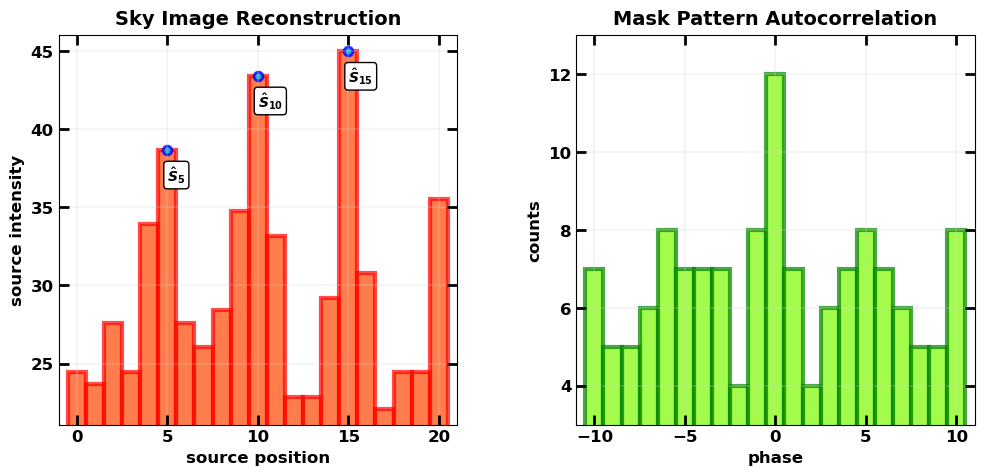

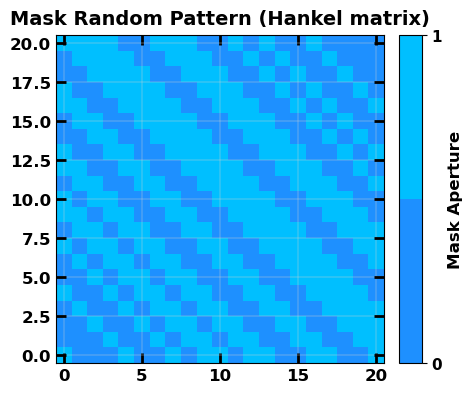

In [82]:
sequence_plot([S_hat, autocorrelation(A)],
              ["Sky Image Reconstruction", "Mask Pattern Autocorrelation"],
              x=[None, np.arange(len(S_hat)) - len(S_hat)//2],
              xlabel=["source position", "phase"],
              ylabel=["source intensity", "counts"],
              color=[(None, None), ("LawnGreen", "g")],
              style=["bar", "bar"],
              simulated_sources=[(S, -2), None])

image_plot([hankel(A[:L], A[-L:])],
           ["Mask Random Pattern (Hankel matrix)"],
           cbarlabel=["Mask Aperture"],
           cbarvalues=[[0, 1]],
           cbarcmap=[ListedColormap(["DodgerBlue", "DeepSkyBlue"])])

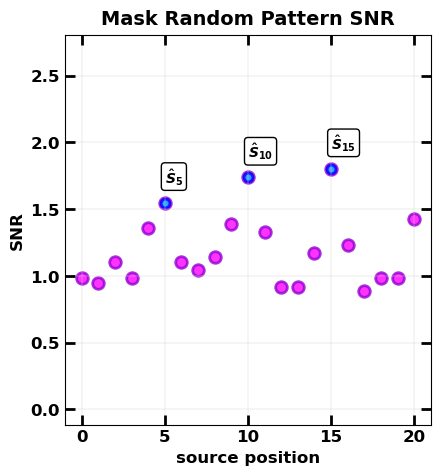

In [86]:
snr_random_mask = SNR(S_hat)

sequence_plot([snr_random_mask], ["Mask Random Pattern SNR"],
              xlabel=["source position"],
              ylabel=["SNR"],
              color=[('Magenta', 'DarkViolet')],
              style=['scatter'],
              simulated_sources=[(S, 0.15)])

### **Uniformly Redundant Array Mask Pattern**

- Uniformly Redundant Arrays (URA) represent a set of binary sequences whose cyclic autocorrelation has constant sidelobe value everywhere, and whose decoding function $G$ is identical to the aperture function $A$ with the exception of the introduction of a normalization factor, and substituting a value of -1 for all zero-valued (opaque) aperture elements.

<center><img src="Images/URA_layout.png" style="width:700px"></center>

In [87]:
def URA_mask(basic_pattern: c.Sequence) -> c.Sequence:
    """
    Returns an array with 0s and 1s build from the chosen basic pattern
    representing the whole coded sequence for the mask.
    """

    cut = (len(basic_pattern) - 1)//2

    prefix = basic_pattern[-cut:]
    suffix = basic_pattern[:cut]

    mask_pattern = np.concatenate((prefix, basic_pattern, suffix))

    return mask_pattern


def decoding_function_URA_mask(A: c.Sequence):
    """
    Computes the decoding function for a URA mask pattern to
    reconstruct the sky image through cross-correlation.
    """

    cut = (len(A) - 1)//4

    return (2*A - 1)/np.sum(A[cut : -cut])

In [88]:
# sky image reconstruction with URA mask pattern
basic_pattern = np.array([1, 1, 1, 0, 1, 0, 0])   # URA basic pattern
A = URA_mask(basic_pattern)                       # URA-based coded mask sequence

S = np.array([0]*len(basic_pattern))              # sources array with intensities S_j
S[2], S[4], S[6] = 8, 16, 24

D = detector_image(A, S, True)                    # detector image with detector background

G = decoding_function_URA_mask(A)                 # mask decoding function

S_hat = sky_image_reconstruction(G, D)            # reconstructed sky image

eps_reconstruction = 1e-14                # test on the reconstruction (algorithms and sources)
eps_sources = 1
reconstruction_algorithms_test(G, D, 'URA', eps_reconstruction)
sources_reconstruction_test(S, S_hat, 'URA', eps_sources)

Sky image reconstruction test (correlation algorithms, URA mask pattern):
 |S_hat_naive - S_hat_hankel| < 1e-14: True
 |S_hat_naive - S_hat_scipy| < 1e-14: True
 |S_hat_hankel - S_hat_scipy| < 1e-14: True

Sky image reconstruction test (sources reconstruction, URA mask pattern):
 |S_hat - S| < 1: True



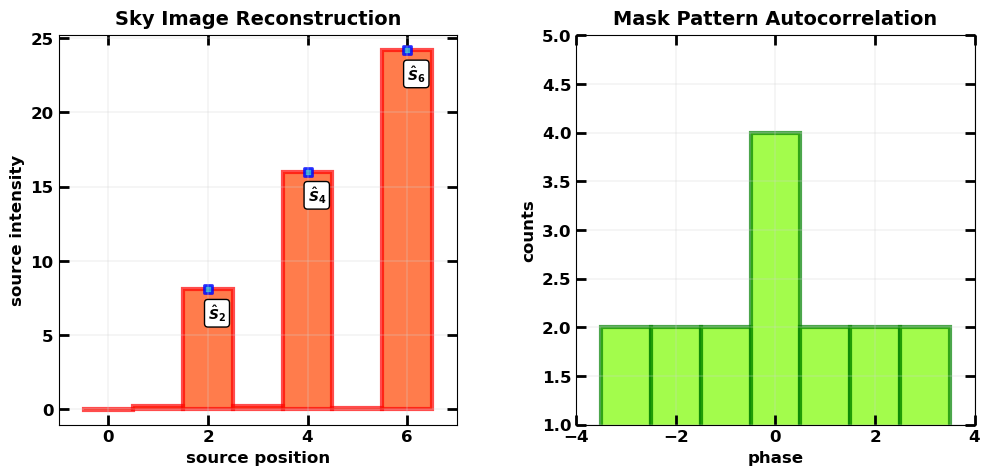

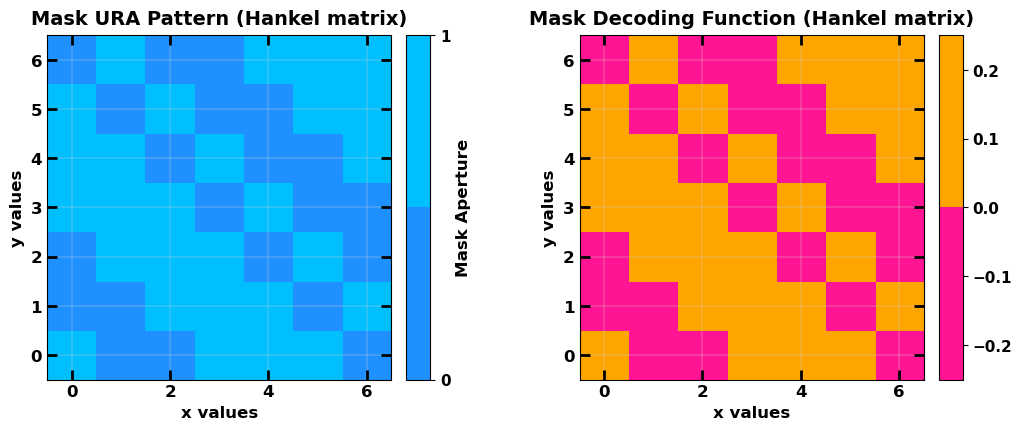

In [109]:
sequence_plot([S_hat, autocorrelation(A)],
              ["Sky Image Reconstruction", "Mask Pattern Autocorrelation"],
              x=[None, np.arange(len(S_hat)) - len(S_hat)//2],
              xlabel=["source position", "phase"],
              ylabel=["source intensity", "counts"],
              color=[(None, None), ("LawnGreen", "g")],
              style=["bar", "bar"],
              simulated_sources=[(S, -2), None])

image_plot([hankel(A[:len(basic_pattern)], A[-len(basic_pattern):]), hankel(G[:len(basic_pattern)], G[-len(basic_pattern):])],
           ["Mask URA Pattern (Hankel matrix)", "Mask Decoding Function (Hankel matrix)"],
           xlabel=["x values"]*2,
           ylabel=["y values"]*2,
           cbarlabel=["Mask Aperture", None],
           cbarvalues=[[0, 1], None],
           cbarcmap=[ListedColormap(["DodgerBlue", "DeepSkyBlue"]), ListedColormap(["DeepPink", "Orange"])])

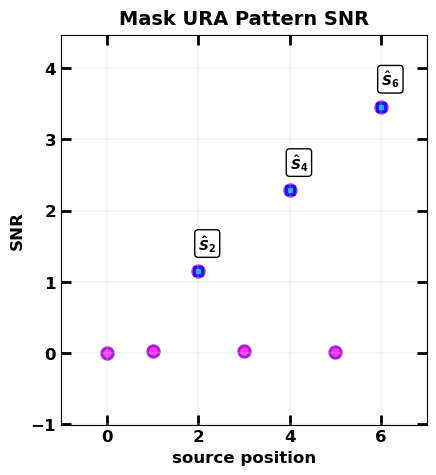

In [108]:
snr_URA_mask = SNR(S_hat)

sequence_plot([snr_URA_mask], ["Mask URA Pattern SNR"],
              xlabel=["source position"],
              ylabel=["SNR"],
              color=[('Magenta', 'DarkViolet')],
              style=['scatter'],
              simulated_sources=[(S, 0.3)])

## **Test with 2D detectors and sky**

### **References**<br>
[1] Gottesman, S. R., "Coded apertures: past, present, and future application and design", 2007